In [11]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

import copy

import sklearn.metrics as skm

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_11832/4004001396.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
# Remove rows with outliers
data = data[data['total sulfur dioxide']<200]

# Z-SCORE ALL VARIABLES EXCEPT FOR QUALITY
# Find the columns we want to normalize (all except quality)
cols_2_zscore = data.keys()
cols_2_zscore = cols_2_zscore.drop('quality')
data[cols_2_zscore] = data[cols_2_zscore].apply(stats.zscore)

qual_threshold = 5
# Create a new column for binarized (boolean) quality
temp = (data['quality'] > qual_threshold).astype(int)
data['boolQuality'] = temp

In [5]:
# Convert from pandas dataframe to tensor
dataT  = torch.tensor(data=data[cols_2_zscore].values).float()
labels = torch.tensor(data=data['boolQuality'].values).float()
labels = labels[:, None] # Transform to matrix. We'll actually need the labels to be a "tensor"

#  Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = \
    train_test_split(dataT, labels, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data, test_labels)

# Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                          batch_size=test_data_set.tensors[0].shape[0])

# Now for the DL part

In [6]:
class ANN_wine(nn.Module):
    """"
    APRF_WINE
    """
    def __init__(self):
        super().__init__()

        # LAYERS
        # Input layer
        self.input = nn.Linear(11, 16)

        # Hidden layer(s). 'fc' = fully connected
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)

        # Output layer
        self.output = nn.Linear(32, 1)
    
    # Forward pass
    def forward(self, x):
        x = F.relu(input=self.input(x))
        x = F.relu(input=self.fc1(x))
        x = F.relu(input=self.fc2(x))
        x = self.output(x)

        return x

# A function to train the model

In [8]:
# Global parameter
num_epochs = 1000

def train_the_model():
  """
  APRF_WINE
  """
  # Continuous value
  loss_func = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(wine_net.parameters(), lr=0.01)

  # Initialize accuracies as empties
  train_acc = []
  test_acc  = []

  # initialize losses
  losses = torch.zeros(num_epochs)

  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Activate training mode
    wine_net.train()

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = wine_net(X)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((y_hat > 0) == y).float()).item())

      # Loss from this batch
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy 
    train_acc.append(np.mean(batch_acc))

    # Get average losses across the batches
    losses[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)    
    X, y = next(iter(test_loader))  # Extract x,y from test dataloader
    with torch.no_grad():           # Deactivates autograd
      pred_labels = wine_net(X)

    # Compute accuracy
    test_acc.append(100 * torch.mean(((pred_labels > 0) == y).float()).item())

  # Function output
  return train_acc, test_acc, losses

# Now to create the fitted model

In [9]:
# Create and train a model
wine_net = ANN_wine()
train_acc, test_acc, losses = train_the_model()

# Compute the performance measures on the train and test data

In [10]:
# Predictions for Training data
train_predictions = wine_net(train_loader.dataset.tensors[0])

# Predictions for Training data
test_predictions  = wine_net(test_loader.dataset.tensors[0])

# Using scikitlearn to compute APRF
# Initialize vectors
train_metrics   = [0, 0, 0, 0]
test_metrics    = [0, 0, 0, 0]

# Training
train_metrics[0] = skm.accuracy_score(y_true=train_loader.dataset.tensors[1], y_pred=(train_predictions > 0))
train_metrics[1] = skm.precision_score(y_true=train_loader.dataset.tensors[1], y_pred=(train_predictions > 0))
train_metrics[2] = skm.recall_score(y_true=train_loader.dataset.tensors[1], y_pred=(train_predictions > 0))
train_metrics[3] = skm.f1_score(y_true=train_loader.dataset.tensors[1], y_pred=(train_predictions > 0))

# Test
test_metrics[0] = skm.accuracy_score(y_true=test_loader.dataset.tensors[1], y_pred=(test_predictions > 0))
test_metrics[1] = skm.precision_score(y_true=test_loader.dataset.tensors[1], y_pred=(test_predictions > 0))
test_metrics[2] = skm.recall_score(y_true=test_loader.dataset.tensors[1], y_pred=(test_predictions > 0))
test_metrics[3] = skm.f1_score(y_true=test_loader.dataset.tensors[1], y_pred=(test_predictions > 0))

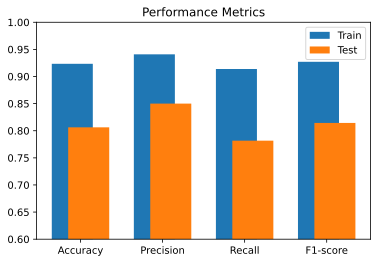

In [15]:
plt.bar(x=np.arange(4) - 0.1, height=train_metrics, width=0.5)
plt.bar(x=np.arange(4) + 0.1, height=test_metrics, width=0.5)
plt.xticks([0, 1, 2, 3], ['Accuracy', 'Precision', 'Recall', 'F1-score'])
plt.ylim([0.6, 1])
plt.legend(['Train', 'Test'])
plt.title('Performance Metrics')
plt.show()

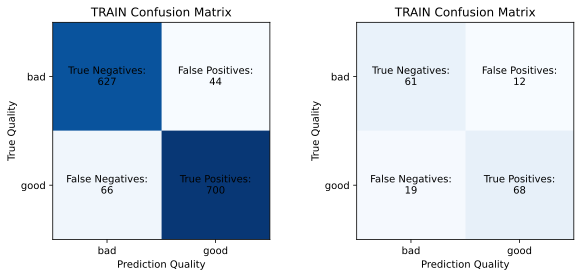

In [30]:
# CONFUSION MATRICES
train_conf  = skm.confusion_matrix(y_true=train_loader.dataset.tensors[1], y_pred=(train_predictions > 0))
test_conf   = skm.confusion_matrix(y_true=test_loader.dataset.tensors[1], y_pred=(test_predictions > 0))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# During TRAIN
ax[0].imshow(train_conf, 'Blues', vmax=len(train_predictions) / 2)
ax[0].set_xticks([0, 1])
ax[0].set_yticks([0, 1])
ax[0].set_xticklabels(['bad', 'good'])
ax[0].set_yticklabels(['bad', 'good'])
ax[0].set_xlabel('Prediction Quality')
ax[0].set_ylabel('True Quality')
ax[0].set_title('TRAIN Confusion Matrix')

# Add text labels
ax[0].text(0, 0, f'True Negatives:\n{train_conf[0, 0]}',   ha='center', va='center')
ax[0].text(0, 1, f'False Negatives:\n{train_conf[1, 0]}',  ha='center', va='center')
ax[0].text(1, 1, f'True Positives:\n{train_conf[1, 1]}',   ha='center', va='center')
ax[0].text(1, 0, f'False Positives:\n{train_conf[0, 1]}',  ha='center', va='center')

# During TEST
ax[1].imshow(test_conf, 'Blues', vmax=len(train_predictions) / 2)
ax[1].set_xticks([0, 1])
ax[1].set_yticks([0, 1])
ax[1].set_xticklabels(['bad', 'good'])
ax[1].set_yticklabels(['bad', 'good'])
ax[1].set_xlabel('Prediction Quality')
ax[1].set_ylabel('True Quality')
ax[1].set_title('TRAIN Confusion Matrix')

# Add text labels
ax[1].text(0, 0, f'True Negatives:\n{test_conf[0, 0]}',   ha='center', va='center')
ax[1].text(0, 1, f'False Negatives:\n{test_conf[1, 0]}',  ha='center', va='center')
ax[1].text(1, 1, f'True Positives:\n{test_conf[1, 1]}',   ha='center', va='center')
ax[1].text(1, 0, f'False Positives:\n{test_conf[0, 1]}',  ha='center', va='center')

plt.show()


# Additional explorations

In [ ]:
# 1) The confusion matrices are rotated, in the sense that most visualizations (outside of Python) have reality in the columns
#    and predictions in the rows. Change the code to get the matrices in the orientation shown in the slides. Make sure
#    all the labels are correct! (hint: you might need to consult the help file: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
# 
# 2) Normalize the confusion matrix to 'all' (the total N). The numbers are so long that they're difficult to read! Change
#    the text drawing code to transform the proportion into percent, and show only the first 2 digits after the period.
# 